In [25]:
#Import libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xlwings import view

In [ ]:
#Read dataset
train_df = pd.read_csv('data/train.csv', sep = ',')
test_df = pd.read_csv('data/test.csv', sep = ',')

### Check of data

In [ ]:
#Shape
print("----- SHAPE -----")
train_df.shape

In [ ]:
#Info
print("----- INFO -----")
train_df.info()

In [54]:
#Checking for missing value
missing_values_count = train_df.isnull().sum()
missing_columns = missing_values_count[missing_values_count>0]

missing_values_percent = train_df.isnull().mean() * 100

# Display columns with missing values and their percentages
missing_columns_percent = missing_values_percent[missing_values_percent > 0]
missing_columns_percent


LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

In [ ]:
#Plot of missing values: 
plt.figure(figsize=(12,6))
sns.heatmap(train_df.isnull(), cbar=False)
plt.show()

### Plots 

#### Distribution of house prices

In [ ]:
#Plots
sns.histplot(train_df['SalePrice'])

#### Distribution of numerical features 


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

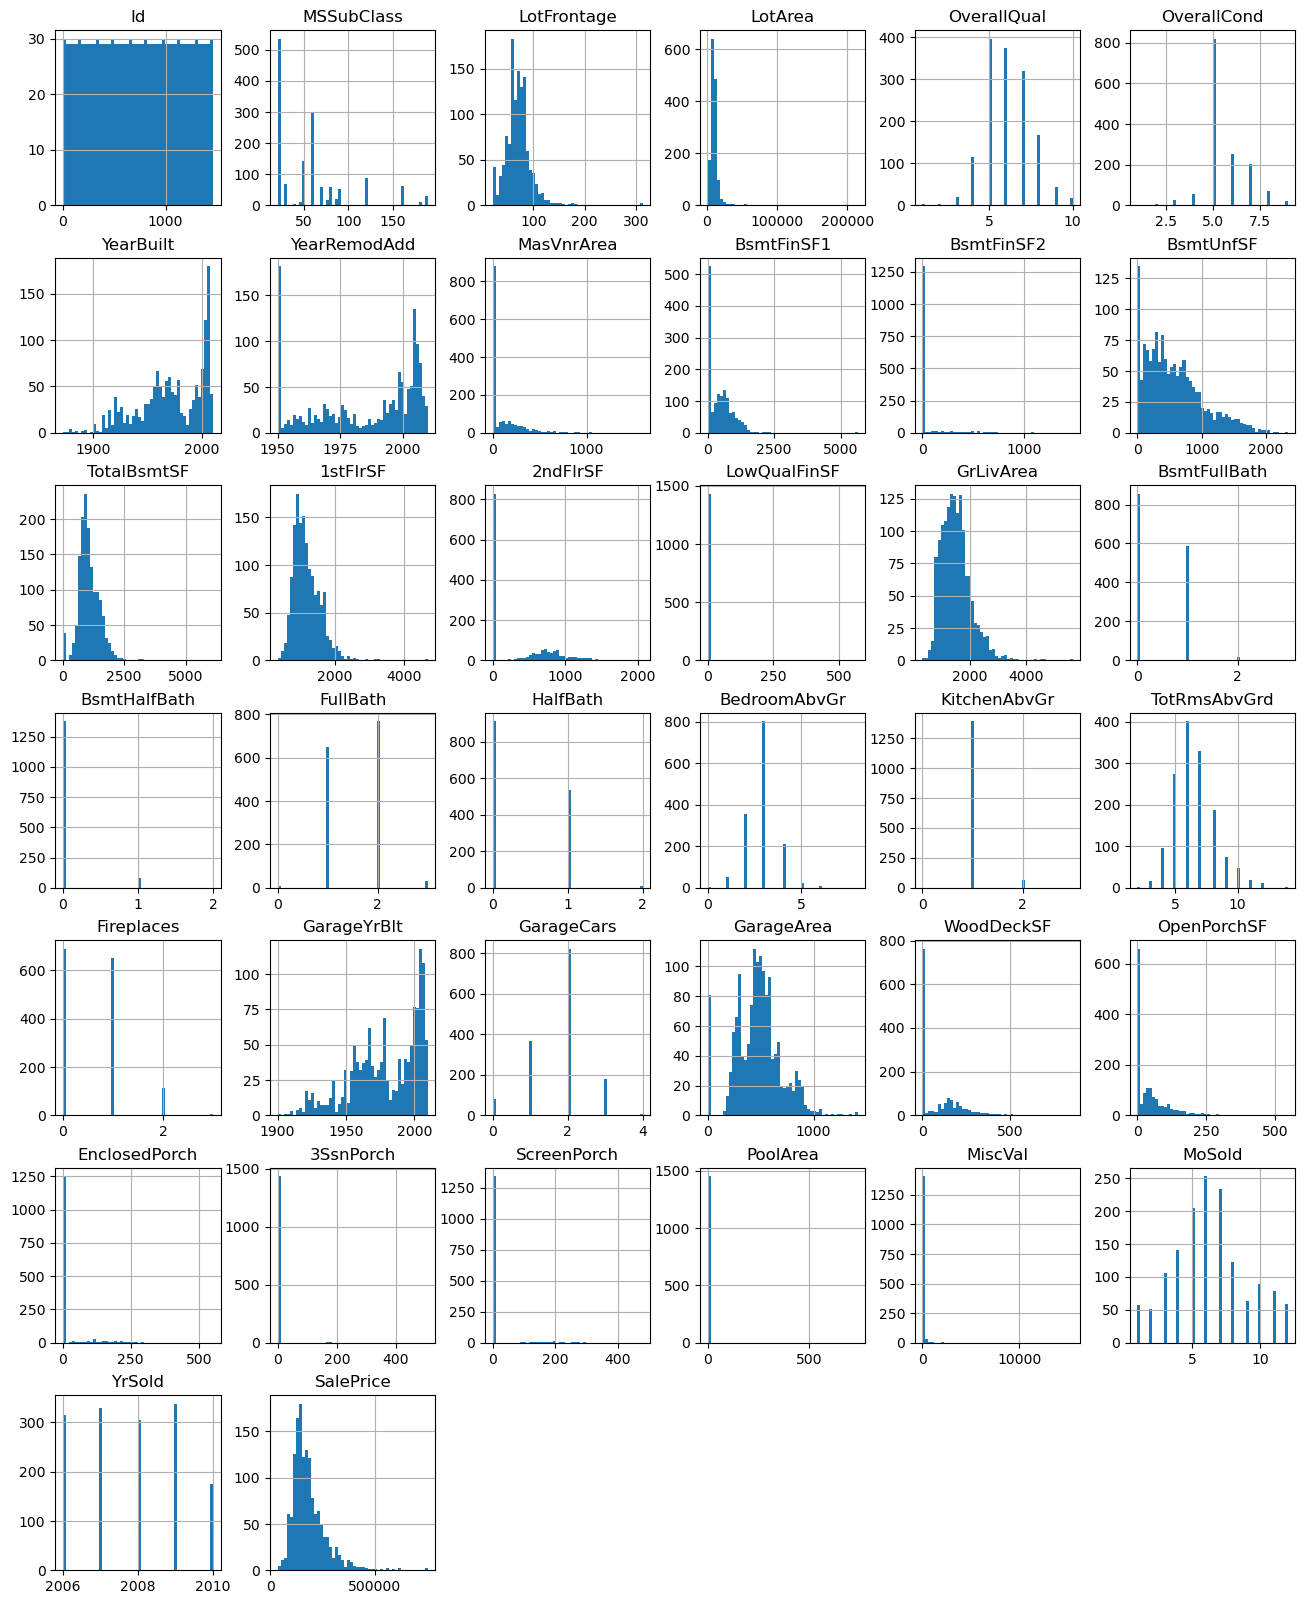

In [53]:
list(set(train_df.dtypes.to_list()))
train_df_num = train_df.select_dtypes(include = ['float64', 'int64'])
train_df_num.hist(figsize=(16,20), bins = 50, xlabelsize=8, ylabelsize=8)

In [65]:
df = train_df[train_df['PoolArea'] > 0]
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
810,811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000
1170,1171,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,...,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal,171000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1386,1387,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000
1423,1424,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970


/var/folders/_0/wx2hxqy90vl4lrsknhfp343w0000gn/T/ipykernel_14109/2532619159.py:1: FutureWarning: The provided callable <function median at 0x11e15e200> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  quality_pivot = train_df.pivot_table(index = "OverallQual", values='SalePrice', aggfunc=np.median)


Text(0, 0.5, 'SalePrice')

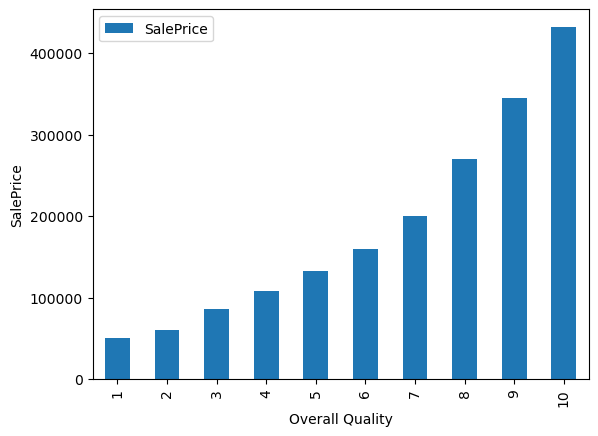

In [37]:
quality_pivot = train_df.pivot_table(index = "OverallQual", values='SalePrice', aggfunc=np.median)
quality_pivot.plot(kind = 'bar')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')

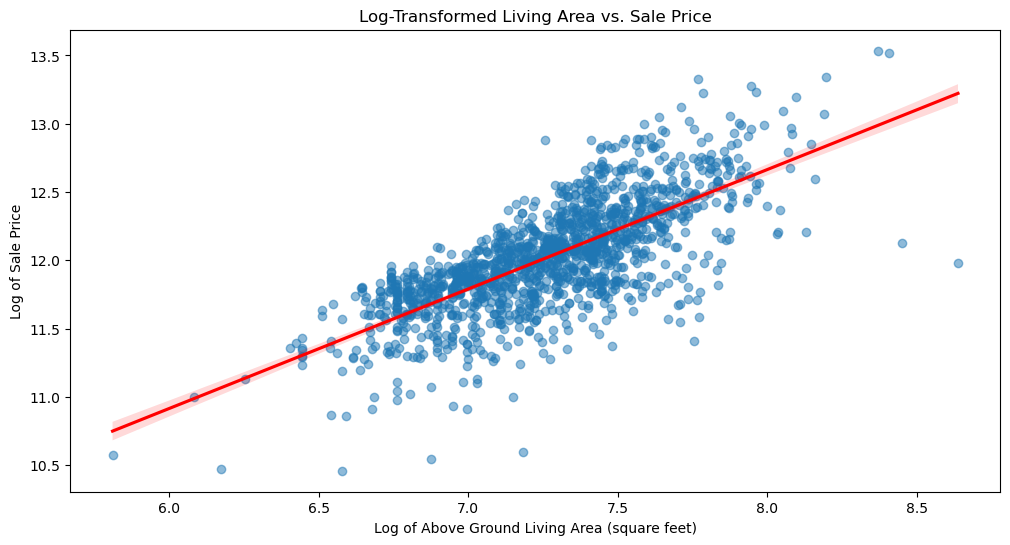

In [46]:
#Normalize the data
train_df_norm = train_df.copy()
train_df_norm['GrLivArea_log'] = np.log(train_df_norm['GrLivArea'])
train_df_norm['SalePrice_log'] = np.log(train_df_norm['SalePrice'])
plt.figure(figsize=(12,6))
data = pd.concat([train_df_norm['GrLivArea_log'], train_df_norm['SalePrice_log']], axis = 1)
sns.regplot(
    data = data,
    x = 'GrLivArea_log',
    y='SalePrice_log', 
    scatter_kws={'alpha':0.5},
    line_kws={'color':'red'}
)
plt.title('Log-Transformed Living Area vs. Sale Price')
plt.xlabel('Log of Above Ground Living Area (square feet)')
plt.ylabel('Log of Sale Price')
plt.show()

In [ ]:
#Unique values 
unique_counts = train_df.nunique()
unique_counts

In [ ]:
#Finding irrelavant features
